In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pfizer-vaccine-tweets/vaccination_tweets.csv


## Importing the Required Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [3]:
tweets = pd.read_csv('/kaggle/input/pfizer-vaccine-tweets/vaccination_tweets.csv')

## Cleaning the Tweets

In [4]:
stop_nltk= stopwords.words("english")
stop_updated= stop_nltk+["https",'t.co','...']
lemm= WordNetLemmatizer()
tweet_tok=  TweetTokenizer()

def clean_text(text):
    tokens= tweet_tok.tokenize(text.lower())
    tokens1 = [re.sub('^https://t.co/[\w]+','',tok) for tok in tokens]
    tokens2 = [re.sub('^@[\w]+','',tok) for tok in tokens1]
    tokens3 = [re.sub('^#[\w]+','',tok) for tok in tokens2]
    tokens4 = [re.sub('[0-9]+','',tok) for tok in tokens3]
    lemmed=[lemm.lemmatize(term) for term in tokens4 if term not in  stop_updated and term not in list(punctuation) and len(term)>2]
    res=' '.join(lemmed)
    return res

In [5]:
tweets['Clean_Tweets']= tweets['text'].apply(clean_text)

# Sentiment Analysis through VADER

In [6]:
analyser= SentimentIntensityAnalyzer() 

def get_vader_sentiment(sent):
    return analyser.polarity_scores(sent)['compound']

tweets['sent_vader']= tweets['Clean_Tweets'].apply(get_vader_sentiment)

sent_pred=[]
for i in range(len(tweets['sent_vader'])):
    if tweets['sent_vader'][i]>=0.05:
        sent_pred.append('positive')
    elif tweets['sent_vader'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

tweets['sent_pred']= sent_pred

# Sentiment Analysis through TextBlob

In [7]:
def get_textblob_sentiment(sent):
    return TextBlob(sent).sentiment.polarity


tweets['sent_TextBlob']= tweets['Clean_Tweets'].apply(get_textblob_sentiment)

sent_pred=[]
for i in range(len(tweets['sent_TextBlob'])):
    if tweets['sent_TextBlob'][i]>=0.05:
        sent_pred.append('positive')
    elif tweets['sent_TextBlob'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

tweets['sent_predTextBlob']= sent_pred

## Percentage of Tweets classified into each category

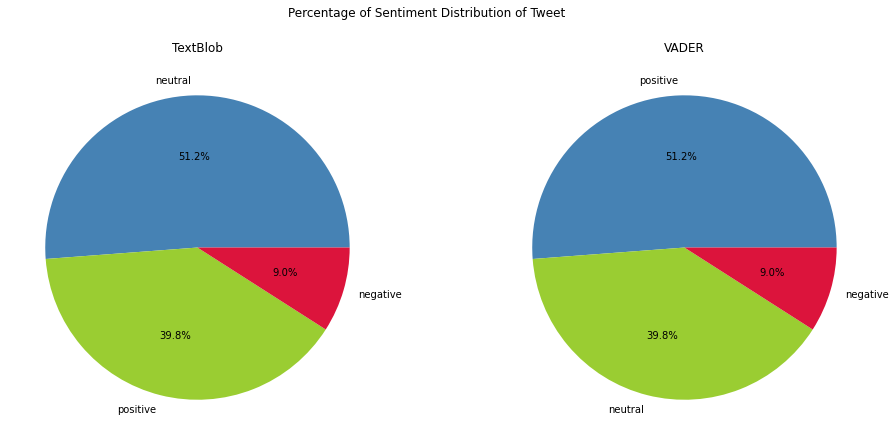

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Percentage of Sentiment Distribution of Tweet')

# TextBlob
perc = pd.DataFrame((tweets['sent_predTextBlob'].value_counts()/len(tweets))*100)
perc.reset_index(inplace=True)
perc.columns = ['Sentiment','Percentage']
axes[0].pie(perc['Percentage'],
        labels=perc['Sentiment'],
        autopct='%1.1f%%',
        colors=['steelblue','yellowgreen','crimson'])
axes[0].set_title("TextBlob")

# VADER
per = pd.DataFrame((tweets['sent_pred'].value_counts()/len(tweets))*100)
per.reset_index(inplace=True)
per.columns = ['Sentiment','Percentage']
axes[1].pie(perc['Percentage'],
        labels=per['Sentiment'],
        autopct='%1.1f%%',
        colors=['steelblue','yellowgreen','crimson'])
axes[1].set_title("VADER")
fig.show()

## Favourites received based on Sentiment of Tweet

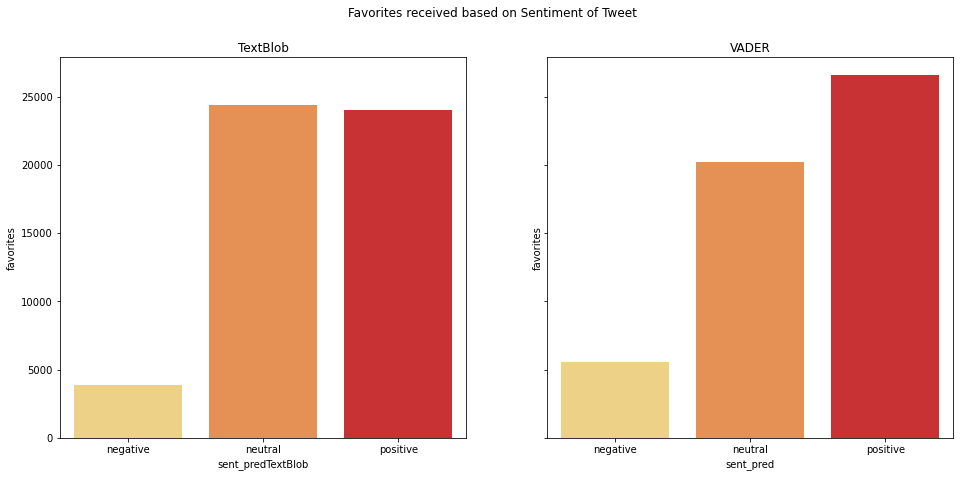

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Favorites received based on Sentiment of Tweet')

# TextBlob
a = pd.DataFrame(tweets.groupby(['sent_predTextBlob'])['favorites'].sum())
sns.barplot(ax=axes[0], x=a.index, y=a['favorites'], palette= 'YlOrRd')
axes[0].set_title("TextBlob")

# VADER
b = pd.DataFrame(tweets.groupby(['sent_pred'])['favorites'].sum())
sns.barplot(ax=axes[1], x=b.index, y=b['favorites'], palette= 'YlOrRd')
axes[1].set_title("VADER")
fig.show()

## Retweets based on Sentiment of Tweet

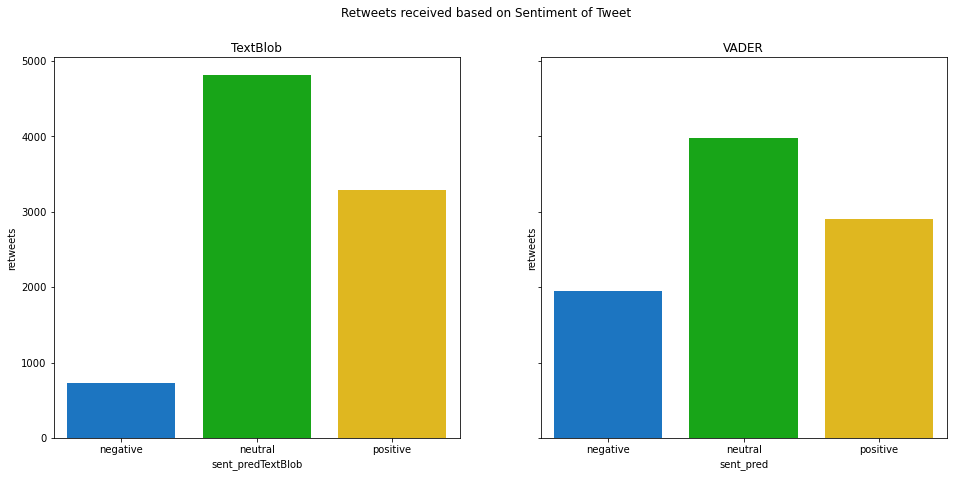

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Retweets received based on Sentiment of Tweet')

# TextBlob
a = pd.DataFrame(tweets.groupby(['sent_predTextBlob'])['retweets'].sum())
sns.barplot(ax=axes[0], x=a.index, y=a['retweets'], palette= 'nipy_spectral')
axes[0].set_title("TextBlob")

# VADER
b = pd.DataFrame(tweets.groupby(['sent_pred'])['retweets'].sum())
sns.barplot(ax=axes[1], x=b.index, y=b['retweets'], palette= 'nipy_spectral')
axes[1].set_title("VADER")
fig.show()

## Conclusion

* TextBlob classifed 51.0% of Tweets to be Neutral sentiment, while, VADER classified 39.8% tweets to Neutral sentiment
* TextBlob classified 39.8% Tweets as Positivie, while VADER classified 51.0% tweets as Postive sentiment
* Both TextBlob & VADER classified 9.0% Tweets as Negative sentiment
* Maximum Favorites are receieved by Neutral sentiment Tweets according to TextBlob, while according to VADER maximum Favorites are received by Positive sentiment Tweets
* Both TextBlob & VADER reveal that Maximum Retweets are received by Neutral Sentiement Tweets
